In [1]:
from spectral import *
import spectral.io.envi as envi
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import matplotlib

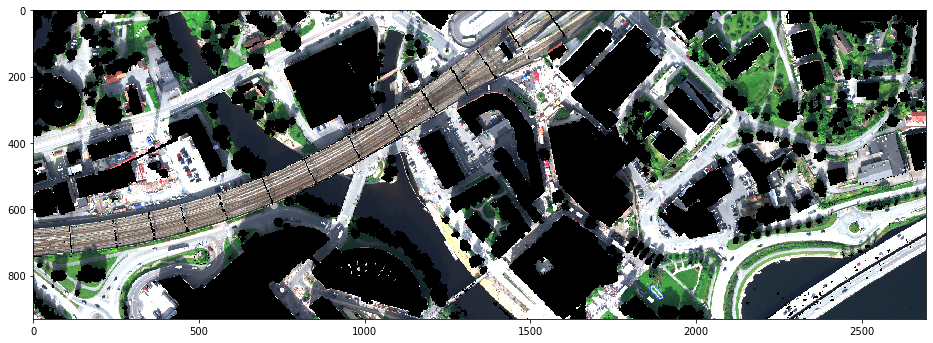

In [2]:
image = envi.open('../../../hyperImage/radiance/VNIR/09_Rad_VNIR_masked.hdr', '../../../hyperImage/radiance/VNIR/09_Rad_VNIR_masked')
img = image.load()
view = imshow(img, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)), figsize=(16, 16))

In [3]:
image.shape

(931, 2694, 186)

In [4]:
#compute PCA on the image 
pc = principal_components(image)
pc_0999 = pc.reduce(fraction=0.999)
img_pc = pc_0999.transform(image)
img_pc.shape

Covariance.....  0.0Covariance.....  0.0Covariance.....done  


(931, 2694, 16)

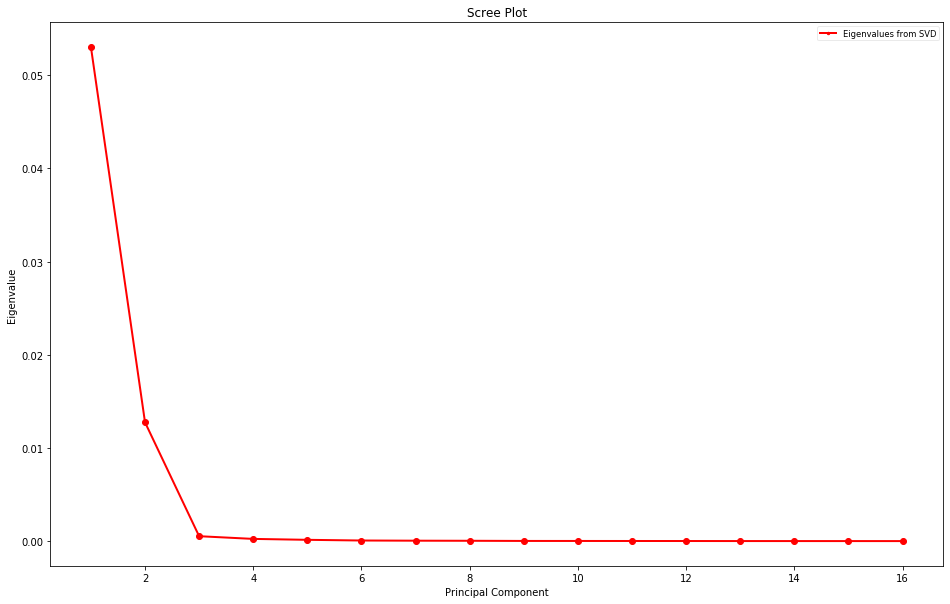

In [5]:
eigvals = pc_0999.eigenvalues
num_vars = 16


fig = plt.figure(figsize=(16, 10))
sing_vals = np.arange(num_vars) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()

In [6]:
pc_img = img_pc.load
img_pcc = img_pc[:,:,:3]
img_pcc.shape

(931, 2694, 3)

In [7]:
#NDVI calculation of the image 
vi = ndvi(image, 76, 105)
data_ndvi = np.nan_to_num(vi)

/opt/anaconda3/lib/python3.7/site-packages/spectral/algorithms/algorithms.py:1216: RuntimeWarning: invalid value encountered in true_divide
  return (n - r) / (n + r)


In [25]:
## Combine PCA,and ndvi DATA
df_pca = pd.DataFrame(img_pcc.reshape(-1, img_pcc.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, img_pcc.shape[2]+1)]
df_ndvi = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi.columns = [string]
#Concatenate 3 dataframe 
main_df = pd.concat([df_pca, df_ndvi], axis=1, sort=False)
main_df.to_csv('../../../hyperImage/csv/features/Rad_vnir_HSI_feature', index=False)



NameError: name 'img_pcc' is not defined

In [4]:
main_df = pd.read_csv('../../../hyperImage/csv/features/Rad_vnir_HSI_feature')

In [5]:
## Class image
gt_data = Image.open('../../../hyperImage/radiance/VNIR/class1.tif')
#gt_data = Image.open('../../hyperImage/reflectance/vnir/training/train_gt2.tif')
gt = np.array(gt_data)
gt.shape

(931, 2694)

In [6]:
np.unique(gt)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [7]:
df_class = pd.DataFrame(gt.reshape(-1, 1))
string = "Target"
df_class.columns = [string]
df_class.shape

(2508114, 1)

# Using only hyperspectral data 

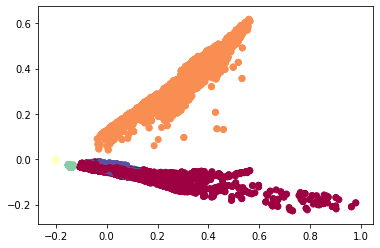

In [8]:
df = pd.concat([main_df, df_class], axis=1, sort=False)
df_masked = df[(df[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral')
plt.show()

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.03537134453654289]
    G: [0.0, 0.039027631282806396]
    B: [0.0, 0.035613398998975754]
>

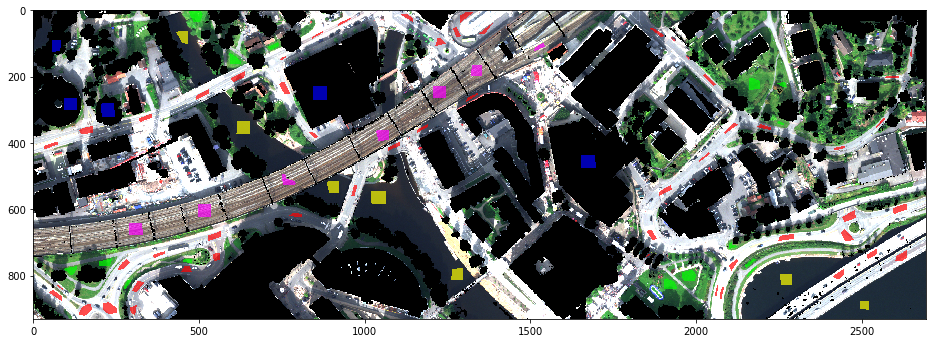

In [9]:
view = imshow(img, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)), figsize=(16, 16), classes=gt)
view.set_display_mode('overlay')
view.class_alpha = 0.7
view.show_data

In [10]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [12]:
random_forest = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=4, n_jobs= -1)
random_forest.fit(X_train, y_train)
pred = random_forest.predict(X_test)
accuracy_score(y_test, pred)

0.9979234648472264

In [13]:
random_forest2 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=4, n_jobs= -1)
random_forest2.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [14]:
X_data = df.drop(columns=['Target']).values
X_data_scaled = scaler.transform(X_data)

In [15]:
y_pred = random_forest2.predict(X_data_scaled)

In [16]:
predicted_hsi_mask = y_pred.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.03537134453654289]
    G: [0.0, 0.039027631282806396]
    B: [0.0, 0.035613398998975754]
>

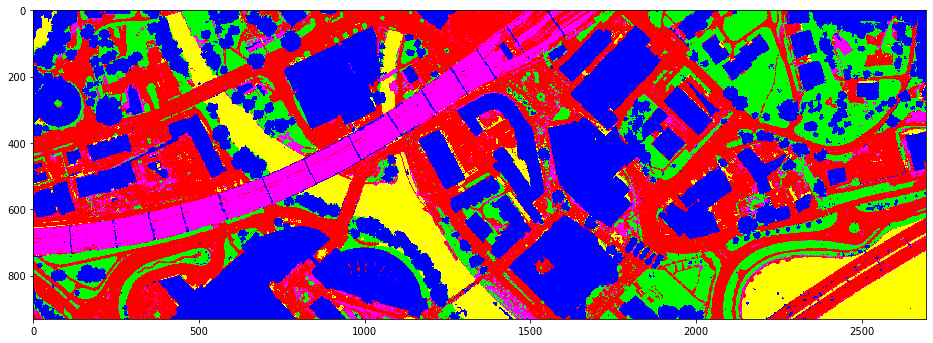

In [17]:
#full_image = envi.open('../hyperImage/reflectance/09_VNIR_POLISHED.hdr', '../hyperImage/reflectance/09_VNIR_POLISHED')
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [ ]:
import scipy as sp


# Convenient functions
def compute_energy(proba,classes,beta):
    """
    The function compute the spatial energy terms of the Potts model
    classes: a 3x3 array containing the labels, the considered pixels is in the "middle" classes[1,1]
    proba:  the conditional probabilities of the considered pixels
    beta: the weight parameter
    """

    # Potts model
    count = (classes!=classes[1,1]).sum()

    # Add spectral and spatial energy
    energy = proba + beta*count

    return energy

# Main function
def icm_fit(proba,labels,beta=4,th=0.000001):
    """
    """
    # Get some parameters and do initialization
    diff = [1]
    niter = 0
    [nl,nc,C]=proba.shape

    # Iterate until convergence
    while (diff[-1] > th) and (niter < 100):
        old_labels= labels.copy() # Make a copy of the old labels
        for i in range(1,nl-1): # Scan each line
            for j in range(1,nc-1): # Scan each column
                energy = []
                labels_ = old_labels[i-1:i+2,j-1:j+2].copy()
                for c in range(C): # Compute the energy for the different classes
                    labels_[1,1] = c+1
                    energy.append(compute_energy(proba[i,j,c],labels_,beta))
                arg = sp.argmin(energy) # Get the maximum energy term for the local configuration
                labels[i,j] = arg + 1
        diff.append(1 - sp.sum(old_labels == labels ).astype(float)/nc/nl) # Compute the changes
        niter += 1
    # Clean data
    del old_labels
    return labels

In [ ]:
proba = -random_forest2.predict_log_proba(X_data_scaled).reshape(img.shape[0], img.shape[1],y.max())


In [ ]:
new_labels = icm_fit(proba,predicted_hsi_mask,beta=1.25,th=0.01)

In [ ]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=new_labels)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [18]:
road = (predicted_hsi_mask == 1).astype(int)

In [19]:
from skimage.feature import canny
from skimage.viewer import ImageViewer
from skimage import io
from skimage import img_as_uint
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)
#viewer = ImageViewer(edges)
#viewer.show()
road_edges = edges.astype(int)


/opt/anaconda3/lib/python3.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.03537134453654289]
    G: [0.0, 0.039027631282806396]
    B: [0.0, 0.035613398998975754]
>

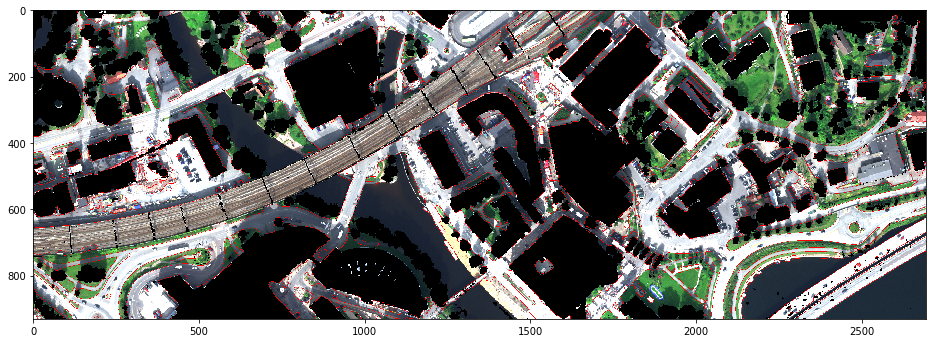

In [20]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# HSI Validation

In [21]:
val_image = envi.open('../../../hyperImage/radiance/VNIR/validation/validation_image.hdr', '../../../hyperImage/radiance/VNIR/validation/validation_image.')
val_img = val_image.load()
val_img.shape

(733, 4239, 186)

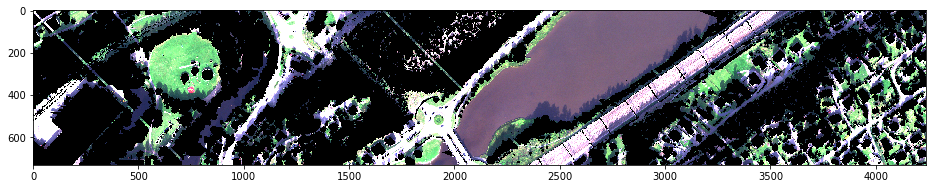

In [22]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16))

In [23]:
#compute PCA on the image 
pc = principal_components(image)
pc_0999 = pc.reduce(fraction=0.999)
val_img_pc = pc_0999.transform(val_image)
val_img_pc.shape

Covariance.....  0.0Covariance.....  0.0Covariance.....done  


(733, 4239, 16)

In [24]:
#NDVI calculation of the image 
vi = ndvi(val_image, 76, 105)
data_ndvi = np.nan_to_num(vi)

/opt/anaconda3/lib/python3.7/site-packages/spectral/algorithms/algorithms.py:1216: RuntimeWarning: invalid value encountered in true_divide
  return (n - r) / (n + r)


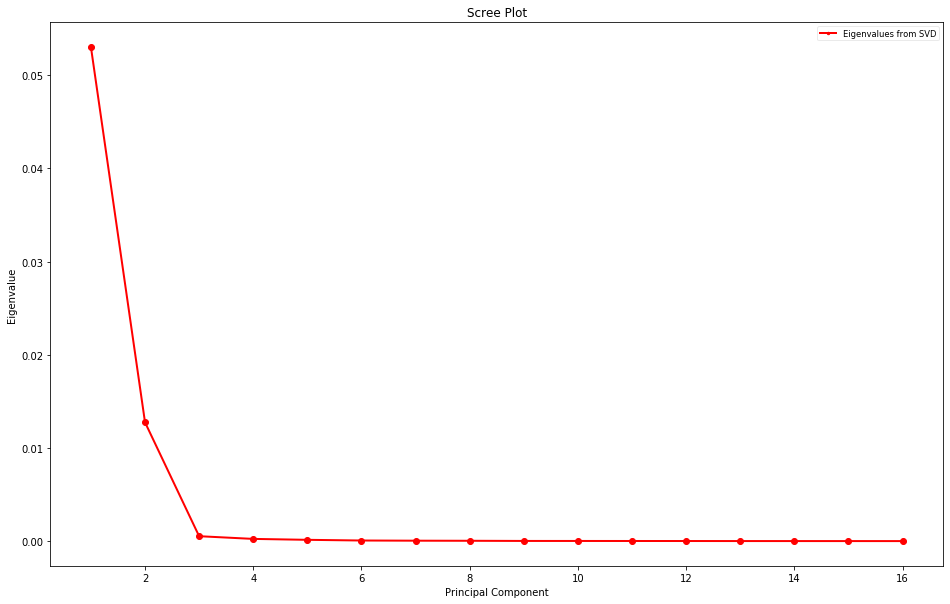

In [26]:
eigvals = pc_0999.eigenvalues
num_vars = 16


fig = plt.figure(figsize=(16, 10))
sing_vals = np.arange(num_vars) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()

In [27]:
pc_img = val_img_pc[:,:,:3]
pc_img.shape

(733, 4239, 3)

In [28]:
## Combine PCA,and ndvi DATA
df_pca = pd.DataFrame(pc_img.reshape(-1, pc_img.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, pc_img.shape[2]+1)]
df_ndvi = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi.columns = [string]
#Concatenate 3 dataframe 
main_df_val = pd.concat([df_pca, df_ndvi], axis=1, sort=False)
main_df_val.to_csv('../../../hyperImage/csv/features/Rad_Vnir_HSI_feature_val', index=False)

In [22]:
main_df_val = pd.read_csv('../../../hyperImage/csv/features/Rad_Vnir_HSI_feature_val')

In [29]:
main_df_val

PC1       PC2       PC3      NDVI
0       -0.199020 -0.003053  0.007214  0.000000
1        0.134572 -0.091507 -0.024189 -0.081914
2        0.134572 -0.091507 -0.024189 -0.081914
3        0.248229 -0.120353 -0.026812 -0.092119
4        0.248229 -0.120353 -0.026812 -0.092119
...           ...       ...       ...       ...
3107182  0.459401  0.484194 -0.012364  0.791776
3107183 -0.199020 -0.003053  0.007214  0.000000
3107184 -0.199020 -0.003053  0.007214  0.000000
3107185  0.084437  0.192991 -0.012090  0.769216
3107186  0.062233  0.175375 -0.009737  0.767097

[3107187 rows x 4 columns]

In [30]:
main_df_val_scaled = scaler.transform(main_df_val)
hsi_val_pred = random_forest.predict(main_df_val_scaled)
predicted_hsi_mask_val = hsi_val_pred.reshape(val_image.shape[0], val_image.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.018543068319559097]
    G: [0.0, 0.025012489408254623]
    B: [0.0, 0.01693692058324814]
>

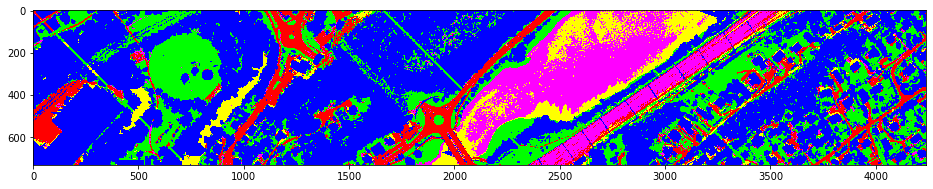

In [31]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [32]:
## Class image
gt_data_val = Image.open('../../../hyperImage/radiance/VNIR/validation/class_val.tif')
gt_val = np.array(gt_data_val)
gt_val.shape

(733, 4239)

In [33]:
df_class_val = pd.DataFrame(gt_val.reshape(-1, 1))
string = "Target"
df_class_val.columns = [string]
df_class_val.shape

(3107187, 1)

In [34]:
df_hsi_val = pd.concat([main_df_val, df_class_val], axis=1, sort=False)

In [35]:
df_hsi_val_masked = df_hsi_val[(df_hsi_val[['Target']] != 0).all(axis=1)]
X_val = df_hsi_val_masked.drop(columns=['Target']).values
y_val = df_hsi_val_masked['Target'].values
X_data_scaled_val = scaler.transform(X_val)
y_pred = random_forest.predict(X_data_scaled_val)

In [36]:
accuracy_score(y_val, y_pred)

0.6421079476195044

In [37]:
target_names = ['Road', 'Vegetation', 'Unclassified', 'Water', 'Train Track']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.89      0.95      0.92     41794
  Vegetation       0.97      1.00      0.98     42633
Unclassified       0.98      0.99      0.98     97928
       Water       0.98      0.24      0.38    186913
 Train Track       0.26      0.87      0.40     58143

    accuracy                           0.64    427411
   macro avg       0.81      0.81      0.73    427411
weighted avg       0.87      0.64      0.63    427411



In [38]:
cohen_kappa_score(y_val, y_pred)

0.5626558822537342

In [39]:
confusion_matrix(y_val, y_pred)

array([[ 39757,    578,    669,    141,    649],
       [     0,  42593,     40,      0,      0],
       [     0,    926,  96942,     59,      1],
       [     2,      0,      0,  44280, 142631],
       [  5096,      0,   1563,    612,  50872]])

# Using Lidar Data Only

In [40]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../../../hyperImage/radiance/VNIR/intensity_masked.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../../../hyperImage/radiance/VNIR/nDSM_masked.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [41]:
df_lidar = pd.concat([df_intensity, df_dsm, df_class], axis=1, sort=False)
df_lidar_masked =  df_lidar[(df_lidar[['Target']] != 0).all(axis=1)]
X = df_lidar_masked.drop(columns=['Target']).values
y = df_lidar_masked['Target'].values

In [42]:
df_lidar

Lidar Intensity  Lidar nDSM  Target
0                -9999.0    -9999.00       0
1                -9999.0    -9999.00       0
2                -9999.0    -9999.00       0
3                -9999.0    -9999.00       0
4                -9999.0    -9999.00       0
...                  ...         ...     ...
2508109          -9999.0        0.02       0
2508110          -9999.0        0.02       0
2508111          -9999.0        0.03       0
2508112          -9999.0        0.00       0
2508113          -9999.0        0.00       0

[2508114 rows x 3 columns]

In [43]:
scaler1 = MinMaxScaler()
scaler1.fit(X)
X_scaled = scaler1.transform(X)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [45]:
random_forest2 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest2.fit(X_train, y_train)
pred = random_forest2.predict(X_test)
accuracy_score(y_test, pred)

0.7843369919905072

In [46]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [47]:
X_lidar_data = df_lidar.drop(columns=['Target']).values
S_lidar_data_scaled = scaler1.transform(X_lidar_data)
y_pred_lidar = random_forest3.predict(S_lidar_data_scaled)
predicted_lidar_mask = y_pred_lidar.reshape(931, 2694)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.03537134453654289]
    G: [0.0, 0.039027631282806396]
    B: [0.0, 0.035613398998975754]
>

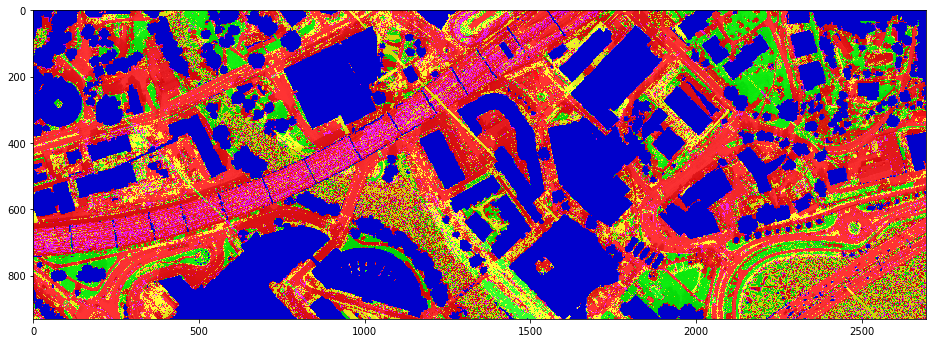

In [48]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 0.8
view.show_data

In [49]:
road = (predicted_lidar_mask == 1).astype(int)

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)

road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.03537134453654289]
    G: [0.0, 0.039027631282806396]
    B: [0.0, 0.035613398998975754]
>

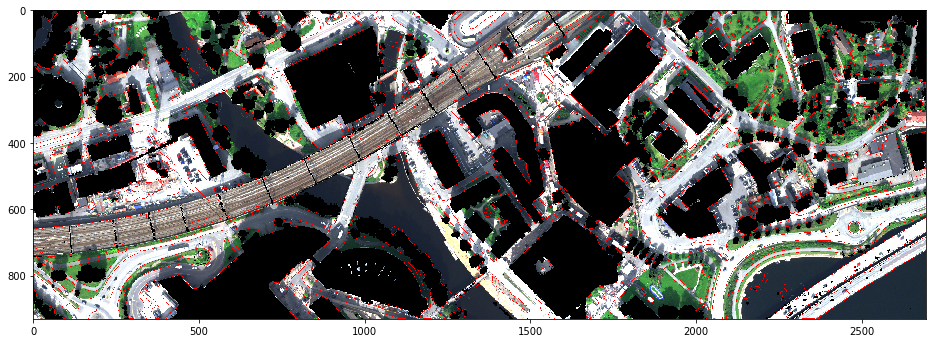

In [51]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

## Lidar Validation

In [52]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../../../hyperImage/radiance/VNIR/validation/validation_intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../../../hyperImage/radiance/VNIR/validation/validation_nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [53]:
l_dsm.shape

(733, 4239)

In [54]:
df_lidar_val = pd.concat([df_intensity, df_dsm], axis=1, sort=False)

In [55]:
df_lidar_val

Lidar Intensity   Lidar nDSM
0                -9999.0     0.000000
1                -9999.0     0.000000
2                -9999.0     0.000000
3                -9999.0 -9999.000000
4                -9999.0 -9999.000000
...                  ...          ...
3107182              4.0     0.080002
3107183              3.0     0.080002
3107184              4.0 -9999.000000
3107185          -9999.0     0.959999
3107186              4.0     0.959999

[3107187 rows x 2 columns]

In [56]:
X_data_scaled = scaler1.transform(df_lidar_val)
val_pred_full = random_forest3.predict(X_data_scaled)
predicted_hsi_lidar_mask_val = val_pred_full.reshape(val_image.shape[0], val_image.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.018543068319559097]
    G: [0.0, 0.025012489408254623]
    B: [0.0, 0.01693692058324814]
>

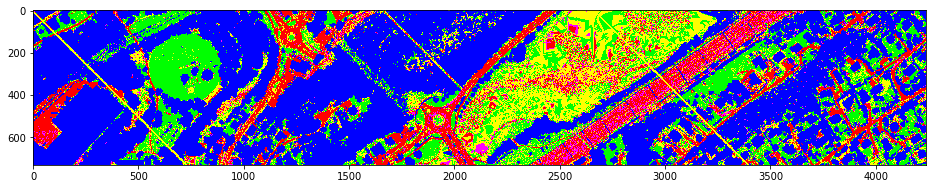

In [57]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [58]:
df_lidar_val_ = pd.concat([df_lidar_val, df_class_val], axis=1, sort=False)
df_lidar_val_

Lidar Intensity   Lidar nDSM  Target
0                -9999.0     0.000000       0
1                -9999.0     0.000000       0
2                -9999.0     0.000000       0
3                -9999.0 -9999.000000       0
4                -9999.0 -9999.000000       0
...                  ...          ...     ...
3107182              4.0     0.080002       0
3107183              3.0     0.080002       0
3107184              4.0 -9999.000000       0
3107185          -9999.0     0.959999       0
3107186              4.0     0.959999       0

[3107187 rows x 3 columns]

In [59]:
df_lidar_val_masked = df_lidar_val_[(df_lidar_val_[['Target']] != 0).all(axis=1)]
X_val = df_lidar_val_masked.drop(columns=['Target']).values
y_val = df_lidar_val_masked['Target'].values

In [60]:
X_data_scaled_val = scaler1.transform(X_val)
y_pred = random_forest3.predict(X_data_scaled_val)

In [61]:
accuracy_score(y_val, y_pred)

0.6508559676751418

In [62]:

print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.35      0.82      0.49     41794
  Vegetation       0.42      0.93      0.58     42633
Unclassified       0.97      0.99      0.98     97928
       Water       0.90      0.50      0.64    186913
 Train Track       0.45      0.25      0.32     58143

    accuracy                           0.65    427411
   macro avg       0.62      0.70      0.60    427411
weighted avg       0.76      0.65      0.65    427411



In [63]:
confusion_matrix(y_val, y_pred)

array([[34156,   849,   964,  2678,  3147],
       [   39, 39810,    62,  2506,   216],
       [  163,   414, 96903,   300,   148],
       [26315, 53512,     0, 92803, 14283],
       [36953,   699,  1646,  4334, 14511]])

In [64]:
cohen_kappa_score(y_val, y_pred)

0.5562304469142525

# Using  hyperspectral and lidar data 

In [65]:
df_lid_hsi = pd.concat([main_df,df_lidar], axis=1, sort=False)

In [66]:
df_lid_hsi

PC1       PC2       PC3      NDVI  Lidar Intensity  Lidar nDSM  \
0       -0.199020 -0.003053  0.007214  0.000000          -9999.0    -9999.00   
1       -0.199020 -0.003053  0.007214  0.000000          -9999.0    -9999.00   
2       -0.199020 -0.003053  0.007214  0.000000          -9999.0    -9999.00   
3       -0.199020 -0.003053  0.007214  0.000000          -9999.0    -9999.00   
4       -0.199020 -0.003053  0.007214  0.000000          -9999.0    -9999.00   
...           ...       ...       ...       ...              ...         ...   
2508109 -0.145634 -0.032510 -0.011160 -0.220177          -9999.0        0.02   
2508110 -0.145634 -0.032510 -0.011160 -0.220177          -9999.0        0.02   
2508111 -0.146038 -0.032228 -0.011899 -0.353088          -9999.0        0.03   
2508112 -0.146038 -0.032228 -0.011899 -0.353088          -9999.0        0.00   
2508113 -0.146514 -0.031940 -0.011214 -0.266117          -9999.0        0.00   

         Target  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
2508109       0  
2508110       0  
2508111       0  
2508112       0  
2508113       0  

[2508114 rows x 7 columns]

In [67]:
df_masked =  df_lid_hsi[(df_lid_hsi[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values

In [68]:
scaler3 = MinMaxScaler()
scaler3.fit(X)
X_scaled = scaler3.transform(X)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_train, y_train)
pred = random_forest3.predict(X_test)
accuracy_score(y_test, pred)

0.9964995550281815

In [70]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [71]:
X_data = df_lid_hsi.drop(columns=['Target']).values
X_data_scaled = scaler3.transform(X_data)

In [72]:
y_pred = random_forest3.predict(X_data_scaled)

In [73]:
predicted_hsi_lidar_mask = y_pred.reshape(931, 2694)

In [74]:
road = (predicted_hsi_lidar_mask == 1).astype(int)

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.03537134453654289]
    G: [0.0, 0.039027631282806396]
    B: [0.0, 0.035613398998975754]
>

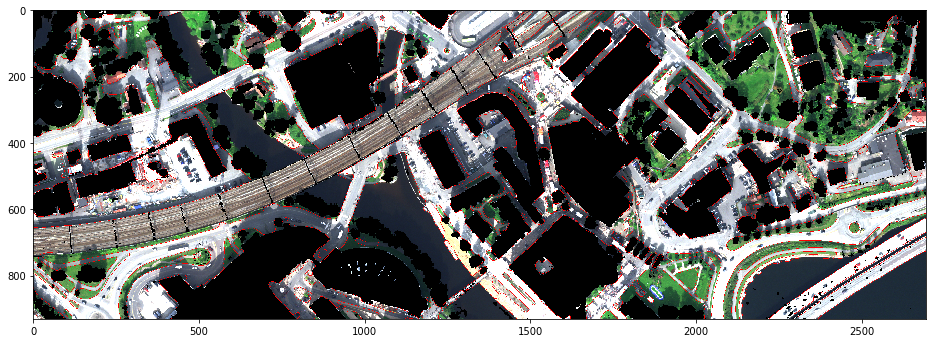

In [76]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.03537134453654289]
    G: [0.0, 0.039027631282806396]
    B: [0.0, 0.035613398998975754]
>

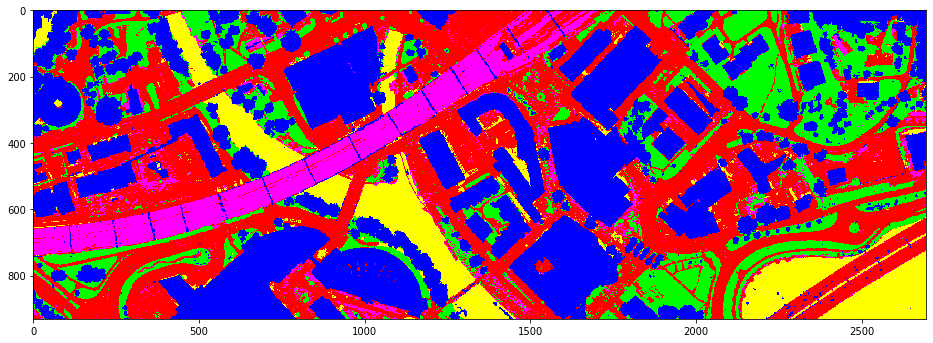

In [77]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation data

In [78]:
df_lid_hsi_val = pd.concat([main_df_val, df_lidar_val], axis=1, sort=False)

In [79]:
df_lid_hsi_val

PC1       PC2       PC3      NDVI  Lidar Intensity   Lidar nDSM
0       -0.199020 -0.003053  0.007214  0.000000          -9999.0     0.000000
1        0.134572 -0.091507 -0.024189 -0.081914          -9999.0     0.000000
2        0.134572 -0.091507 -0.024189 -0.081914          -9999.0     0.000000
3        0.248229 -0.120353 -0.026812 -0.092119          -9999.0 -9999.000000
4        0.248229 -0.120353 -0.026812 -0.092119          -9999.0 -9999.000000
...           ...       ...       ...       ...              ...          ...
3107182  0.459401  0.484194 -0.012364  0.791776              4.0     0.080002
3107183 -0.199020 -0.003053  0.007214  0.000000              3.0     0.080002
3107184 -0.199020 -0.003053  0.007214  0.000000              4.0 -9999.000000
3107185  0.084437  0.192991 -0.012090  0.769216          -9999.0     0.959999
3107186  0.062233  0.175375 -0.009737  0.767097              4.0     0.959999

[3107187 rows x 6 columns]

In [80]:
X_data_scaled = scaler3.transform(df_lid_hsi_val)

In [81]:
val_pred_full = random_forest3.predict(X_data_scaled)

In [82]:
predicted_hsi_lidar_mask_val = val_pred_full.reshape(val_image.shape[0], val_image.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.018543068319559097]
    G: [0.0, 0.025012489408254623]
    B: [0.0, 0.01693692058324814]
>

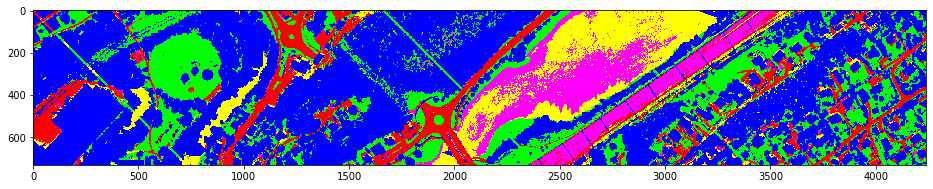

In [83]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [84]:
road = (predicted_hsi_lidar_mask_val == 1).astype(int)

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.018543068319559097]
    G: [0.0, 0.025012489408254623]
    B: [0.0, 0.01693692058324814]
>

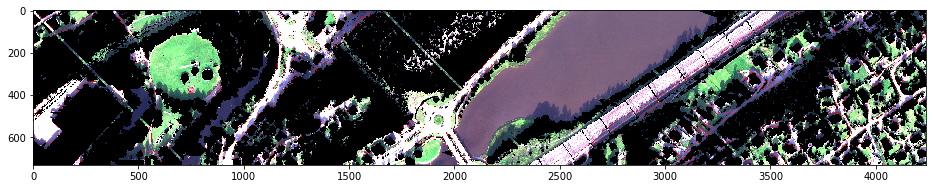

In [86]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [87]:
df_val = pd.concat([df_lid_hsi_val, df_class_val], axis=1, sort=False)
df_val

PC1       PC2       PC3      NDVI  Lidar Intensity   Lidar nDSM  \
0       -0.199020 -0.003053  0.007214  0.000000          -9999.0     0.000000   
1        0.134572 -0.091507 -0.024189 -0.081914          -9999.0     0.000000   
2        0.134572 -0.091507 -0.024189 -0.081914          -9999.0     0.000000   
3        0.248229 -0.120353 -0.026812 -0.092119          -9999.0 -9999.000000   
4        0.248229 -0.120353 -0.026812 -0.092119          -9999.0 -9999.000000   
...           ...       ...       ...       ...              ...          ...   
3107182  0.459401  0.484194 -0.012364  0.791776              4.0     0.080002   
3107183 -0.199020 -0.003053  0.007214  0.000000              3.0     0.080002   
3107184 -0.199020 -0.003053  0.007214  0.000000              4.0 -9999.000000   
3107185  0.084437  0.192991 -0.012090  0.769216          -9999.0     0.959999   
3107186  0.062233  0.175375 -0.009737  0.767097              4.0     0.959999   

         Target  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
3107182       0  
3107183       0  
3107184       0  
3107185       0  
3107186       0  

[3107187 rows x 7 columns]

In [88]:
df_masked_val = df_val[(df_val[['Target']] != 0).all(axis=1)]
X_val = df_masked_val.drop(columns=['Target']).values
y_val = df_masked_val['Target'].values
X_data_scaled_val = scaler3.transform(X_val)
val_pred_full_ = random_forest3.predict(X_data_scaled_val)

In [89]:
accuracy_score(y_val, val_pred_full_)

0.768971785939061

In [90]:
print(classification_report(y_val, val_pred_full_, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.88      0.96      0.91     41794
  Vegetation       0.97      1.00      0.99     42633
Unclassified       0.98      0.99      0.98     97928
       Water       0.99      0.53      0.69    186913
 Train Track       0.36      0.87      0.51     58143

    accuracy                           0.77    427411
   macro avg       0.84      0.87      0.82    427411
weighted avg       0.89      0.77      0.78    427411



In [91]:
cohen_kappa_score(y_val, val_pred_full_)

0.7037333155655598

In [92]:
confusion_matrix(y_val, val_pred_full_)

array([[39916,   571,   678,   137,   492],
       [    0, 42593,    40,     0,     0],
       [    0,   545, 97090,   292,     1],
       [    2,     0,     0, 98686, 88225],
       [ 5566,     0,  1572,   623, 50382]])